<a href="https://colab.research.google.com/github/spazewalker/FER_Doggomaniacs/blob/master/Video_emotion_Recognistion_with_data_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
import itertools 
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Conv2D, Input, Dense, MaxPool2D,BatchNormalization,Flatten,ZeroPadding2D,Activation,Dropout,LSTM
from keras.layers import TimeDistributed
from keras.models import Model,Sequential
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
%matplotlib inline

In classifier model I have removed the Sotftmax Layer and added a Dense layer to give embedding of length 128.

In [17]:
def classifierModel(X_input):
  '''
  Layer 1
  '''
  X = TimeDistributed(Conv2D(64,(7,7),strides=(2,2),name = 'conv2',activation='relu'))(X_input)
  X = TimeDistributed(MaxPool2D((3,3),strides=(2,2),name='max_pool2'))(X)
  X = TimeDistributed(BatchNormalization())(X)

  '''
  Layer 2
  '''
  X1 = TimeDistributed(Conv2D(96,(1,1),name='conv4',activation='relu'))(X)
  X2 = TimeDistributed(MaxPool2D((3,3),strides=(1,1),name='max_pool3'))(X)
  X3 = TimeDistributed(Conv2D(208,(3,3),name='conv5',activation='relu'))(X1)
  X4 = TimeDistributed(Conv2D(64,(1,1),name='conv6',activation='relu'))(X2)
  print(X1.shape,X2.shape)
  chunk_1 = keras.layers.concatenate([X3,X4],axis=-1)

  '''
  Layer 3
  '''
  X5 = TimeDistributed(Conv2D(96,(1,1),name='conv7',activation='relu'))(chunk_1)
  X6 = TimeDistributed(MaxPool2D((3,3),strides=(1,1),name='max_pool4'))(chunk_1)
  X7 = TimeDistributed(Conv2D(208, (3,3),name='conv8',activation='relu'))(X5)
  X8 = TimeDistributed(Conv2D(64,(1,1),name='conv9',activation='relu'))(X6)
  chunk_2 = keras.layers.concatenate([X7,X8],axis=-1)
  '''
  Layer 4
  '''
  out = TimeDistributed(Flatten())(chunk_2)
  out = TimeDistributed(Dropout(0.5))(out)
  out = TimeDistributed(Dense(128,activation = 'linear'))(out)
  return out


1. Clip size will be fixed i.e. the number of images during transition of emotion.
2. s0 and c0 are the initial hidden state and cell state for LSTM
3. Outputs will be an array storing the output of each LSTM cell 
4. Then we will take the last output of LSTM cell as our final output 

In [29]:
def LSTM_model(input_shape):
  X_input = Input(shape = input_shape)
  X = classifierModel(X_input)
  X = LSTM(128)(X)
  X = Dense(8,activation='softmax')(X)
  model = Model(inputs = X_input,outputs = X)
  return model

Clip size yet to be decided and it will be same as hidden_state_size because there will be equal number of LSTM units as number of images in a clip.


In [30]:
model1 = LSTM_model((12,48,48,1))

(None, 12, 10, 10, 96) (None, 12, 8, 8, 64)


In [31]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
model1.summary()  

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12, 48, 48, 1 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 12, 21, 21, 6 3200        input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 12, 10, 10, 6 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 12, 10, 10, 6 256         time_distributed_2[0][0]         
____________________________________________________________________________________________

In [26]:
emotion_model = keras.models.load_model('/content/drive/My Drive/data/urbi_trained.h5')

In [27]:
emotion_model.layers.pop()
emotion_model.layers.pop()
emotion_model.layers.pop()
emotion_model.outputs = [emotion_model.layers[-1].output]

In [28]:
for layer in emotion_model.layers[:-5]:
  layer.trainable = False
for layer in emotion_model.layers[-3:-1]:
  layer.trainable = False
for layer in emotion_model.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f56584a1860> False
<keras.layers.convolutional.Conv2D object at 0x7f56584a18d0> False
<keras.layers.core.Activation object at 0x7f56584a1940> False
<keras.layers.pooling.MaxPooling2D object at 0x7f56584a1ac8> False
<keras.layers.normalization.BatchNormalization object at 0x7f56584a1cc0> False
<keras.layers.convolutional.Conv2D object at 0x7f56584a1b00> False
<keras.layers.core.Activation object at 0x7f56584a1c50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f56584a1f28> False
<keras.layers.convolutional.Conv2D object at 0x7f5658567048> False
<keras.layers.convolutional.Conv2D object at 0x7f56585671d0> False
<keras.layers.core.Activation object at 0x7f5658567358> False
<keras.layers.core.Activation object at 0x7f5658567390> False
<keras.layers.merge.Concatenate object at 0x7f56585673c8> False
<keras.layers.convolutional.Conv2D object at 0x7f5658567400> False
<keras.layers.core.Activation object at 0x7f5658567588> False
<keras.la

In [38]:
def fine_tune(input_shape):
  input = Input(shape=input_shape, name='seq_input')
  x = TimeDistributed(keras.layers.Lambda(lambda x: emotion_model(x)))(input)
  x = TimeDistributed(Flatten())(x)
  x = TimeDistributed(Dense(128))(x)
  x = LSTM(128)(x)
  out = Dense(8,activation='softmax')(x)
  model = Model(inputs = input,outputs = out)
  return model

In [39]:
fine_tuned_model = fine_tune((12,48,48,1))

In [40]:
fine_tuned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Downloading BAUM 2 Dataset from the official website and extracting it to videos folder

Getting cascades to find face and eye

Extracting frames from the video file to use our model on that.

In [41]:
!wget --continue https://github.com/spazewalker/FER_Doggomaniacs/raw/master/ds.zip https://github.com/spazewalker/FER_Doggomaniacs/raw/master/main1.csv && unzip ds.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/S274/004/frames/6.jpg  
  inflating: dataset/S274/004/frames/3.jpg  
  inflating: dataset/S274/004/frames/9.jpg  
  inflating: dataset/S274/004/frames/1.jpg  
  inflating: dataset/S274/004/frames/2.jpg  
  inflating: dataset/S274/004/frames/4.jpg  
  inflating: dataset/S274/004/frames/8.jpg  
  inflating: dataset/S274/004/frames/0.jpg  
  inflating: dataset/S274/004/frames/5.jpg  
  inflating: dataset/S274/004/frames/11.jpg  
   creating: dataset/S274/006/
  inflating: dataset/S274/006/emotion.txt  
   creating: dataset/S274/006/frames/
  inflating: dataset/S274/006/frames/7.jpg  
  inflating: dataset/S274/006/frames/10.jpg  
  inflating: dataset/S274/006/frames/6.jpg  
  inflating: dataset/S274/006/frames/3.jpg  
  inflating: dataset/S274/006/frames/9.jpg  
  inflating: dataset/S274/006/frames/1.jpg  
  inflating: dataset/S274/006/frames/2.jpg  
  inflating: dataset/S274/006/frames/4.jpg  
  inflating: dataset/S27

In [42]:
ds = pd.read_csv("main1.csv")
ds.head()

,frames,emotion
0,dataset/S001/001/frames/,7
1,dataset/S002/001/frames/,2
2,dataset/S002/002/frames/,5
3,dataset/S003/001/frames/,5
4,dataset/S004/001/frames/,5


In [43]:
x = np.array(ds['frames'])
y = pd.get_dummies(ds['emotion']).to_numpy()
print(y[0:4])

[[0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]]


In [44]:
import cv2
import numpy as np

count = len(x)

data = np.empty((1,1,1))
print("data loading. ")
for j in range(len(x)):
    for i in range(12):
        arr = cv2.imread(x[j]+str(i)+'.jpg',cv2.IMREAD_GRAYSCALE)
        data = np.append(data,arr)
        print('\r{}%'.format(j/len(x)*100),end='')
        # print(arr.shape)
        # break
data = np.delete(data,0)
data = data.reshape(count,12,48,48,1)
print('\r100%\nFinal Shape: ',data.shape)

data loading. 
100%
Final Shape:  (883, 12, 48, 48, 1)


In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=42)

Input_frames are of shape (m,clip_size,input_size)
where input_size for eg. for FER2013 is (48,48,1)

In [33]:
print('X_train: ',X_train.shape,'\nX_test: ',X_test.shape,'\ny_train: ',y_train.shape,'\ny_test: ',y_test.shape)

X_train:  (794, 12, 48, 48, 1) 
X_test:  (89, 12, 48, 48, 1) 
y_train:  (794, 8) 
y_test:  (89, 8)


In [34]:
model1.fit(X_train,y_train,epochs=16,batch_size = 32,validation_data=(X_test,y_test))

Train on 794 samples, validate on 89 samples
Epoch 1/16
794/794 [==============================] - 3s 4ms/step - loss: 2.0305 - accuracy: 0.2065 - val_loss: 1.9108 - val_accuracy: 0.2135
Epoch 2/16
794/794 [==============================] - 2s 3ms/step - loss: 1.9704 - accuracy: 0.1940 - val_loss: 1.8774 - val_accuracy: 0.2472
Epoch 3/16
794/794 [==============================] - 2s 3ms/step - loss: 1.9535 - accuracy: 0.2380 - val_loss: 1.9090 - val_accuracy: 0.2472
Epoch 4/16
794/794 [==============================] - 2s 3ms/step - loss: 1.9619 - accuracy: 0.2393 - val_loss: 1.9008 - val_accuracy: 0.2472
Epoch 5/16
794/794 [==============================] - 2s 3ms/step - loss: 1.9582 - accuracy: 0.2393 - val_loss: 1.8867 - val_accuracy: 0.2472
Epoch 6/16
794/794 [==============================] - 2s 3ms/step - loss: 1.9527 - accuracy: 0.2380 - val_loss: 1.9112 - val_accuracy: 0.2472
Epoch 7/16
794/794 [==============================] - 2s 3ms/step - loss: 1.9491 - accuracy: 0.2406 - v

In [53]:
kf = KFold(n_splits=10)
kf.get_n_splits(x)
print(kf)
fine_tuned_model = fine_tune((12,48,48,1))
fine_tuned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for train_index,test_index in kf.split(X_train,y_train):

  X_train_sub, X_test_sub = X_train[train_index], X_train[test_index]
  y_train_sub, y_test_sub = y_train[train_index], y_train[test_index]
  X_train_sub = X_train_sub.reshape(X_train_sub.shape[0],12,48, 48, 1)
  X_test_sub = X_test_sub.reshape(X_test_sub.shape[0],12,48, 48, 1)

  fine_tuned_model.fit(X_train_sub,y_train_sub,epochs=5,batch_size=128,validation_data=(X_test_sub,y_test_sub))

KFold(n_splits=10, random_state=None, shuffle=False)
Train on 714 samples, validate on 80 samples
Epoch 1/5
714/714 [==============================] - 3s 4ms/step - loss: 1.8419 - accuracy: 0.3221 - val_loss: 2.1068 - val_accuracy: 0.2250
Epoch 2/5
714/714 [==============================] - 1s 918us/step - loss: 1.0642 - accuracy: 0.7507 - val_loss: 2.5049 - val_accuracy: 0.2875
Epoch 3/5
714/714 [==============================] - 1s 917us/step - loss: 0.4899 - accuracy: 0.8950 - val_loss: 3.2773 - val_accuracy: 0.2375
Epoch 4/5
714/714 [==============================] - 1s 911us/step - loss: 0.1433 - accuracy: 0.9762 - val_loss: 3.9610 - val_accuracy: 0.2375
Epoch 5/5
714/714 [==============================] - 1s 895us/step - loss: 0.0346 - accuracy: 0.9972 - val_loss: 4.4216 - val_accuracy: 0.2375
Train on 714 samples, validate on 80 samples
Epoch 1/5
714/714 [==============================] - 1s 905us/step - loss: 0.3295 - accuracy: 0.9300 - val_loss: 3.8105 - val_accuracy: 0.0875
E

In [46]:
fine_tuned_model.fit(X_train,y_train,epochs=16,batch_size = 32,validation_data=(X_test,y_test))

Train on 794 samples, validate on 89 samples
Epoch 1/16
794/794 [==============================] - 8s 10ms/step - loss: 1.6592 - accuracy: 0.3778 - val_loss: 2.2507 - val_accuracy: 0.1798
Epoch 2/16
794/794 [==============================] - 1s 2ms/step - loss: 0.6189 - accuracy: 0.8451 - val_loss: 3.1707 - val_accuracy: 0.0899
Epoch 3/16
794/794 [==============================] - 1s 2ms/step - loss: 0.0899 - accuracy: 0.9824 - val_loss: 4.3318 - val_accuracy: 0.0562
Epoch 4/16
794/794 [==============================] - 1s 2ms/step - loss: 0.0263 - accuracy: 0.9950 - val_loss: 4.4194 - val_accuracy: 0.1236
Epoch 5/16
794/794 [==============================] - 1s 2ms/step - loss: 0.0109 - accuracy: 0.9975 - val_loss: 3.5119 - val_accuracy: 0.1910
Epoch 6/16
794/794 [==============================] - 1s 2ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 4.0570 - val_accuracy: 0.1798
Epoch 7/16
794/794 [==============================] - 1s 2ms/step - loss: 0.0020 - accuracy: 1.0000 - 

In [47]:
class_names = ['Neutral', 'Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Sad','Suprise']
def plot_confusion_matrix(
        cm,
        classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,color = 'black')
    plt.yticks(tick_marks, classes,color = 'black')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12,color='black')
    plt.xlabel('Predicted label', fontsize=12,color='black')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')

In [54]:
ans = np.argmax(fine_tuned_model.predict(X_test),axis=-1)
y_test_ = np.argmax(y_test,axis=1)

Normalized confusion matrix
[[0.45       0.         0.         0.         0.         0.25
  0.3        0.        ]
 [0.52631579 0.         0.         0.         0.         0.10526316
  0.36842105 0.        ]
 [0.5        0.         0.         0.         0.         0.
  0.5        0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.4        0.         0.         0.2        0.         0.
  0.4        0.        ]
 [0.36363636 0.         0.         0.         0.         0.5
  0.13636364 0.        ]
 [0.33333333 0.         0.         0.         0.         0.33333333
  0.33333333 0.        ]
 [0.33333333 0.         0.         0.         0.         0.16666667
  0.5        0.        ]]


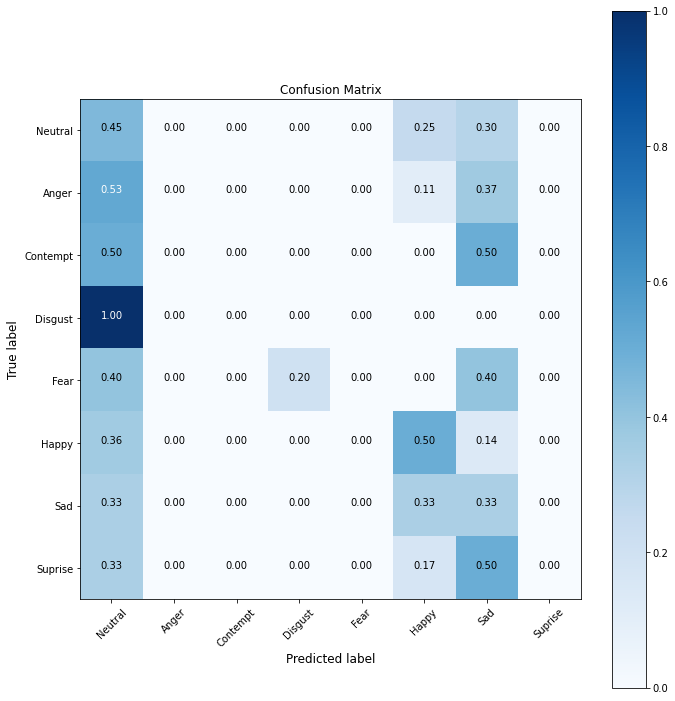

In [55]:
matrix = confusion_matrix(y_test_,ans)
plot_confusion_matrix(
        matrix,
        classes=class_names,
        normalize=True,
        title='Confusion Matrix')